In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from scipy.stats import spearmanr
import re
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
concentrations = {
    'c1': 10e-6,
    'c2': 3e-6,
    'c3': 1e-6,
}
concentrations.update({'LC': min(concentrations.values()) / 1e3})

In [3]:
def read_data(compound='TI26', assay='TNF'):
    bname = '../../resources/cell-based-assays/Tina-email-2023-08-31/'
    fpath = bname + compound + '_' + assay + '.txt'
    data = pd.read_csv(fpath, sep='\t')
    return(data)

data = read_data(compound='TI26', assay='TNF')
data

,VC,c1,c2,c3,RI,LC
0,0.917858,0.755247,9.443050,36.121420,1.403177,13.312150
1,1.303890,7.497930,11.304590,1.577535,0.268734,2.062547
2,0.706698,0.442091,12.486180,28.991770,0.276541,1.752594
3,0.771455,0.958683,4.763406,17.613260,0.812029,1.262600
4,0.394515,0.909701,4.902034,1.180168,0.191152,0.593902
5,0.489854,1.303890,3.428685,8.875549,1.594178,51.612920


In [4]:
def reshape_data(data, concentrations=concentrations):
    df = data[concentrations.keys()].stack().to_frame('activity')
    df['conc'] = [concentrations[c] for c in df.index.get_level_values(1)]
    concentrations_log10 = {k: np.log10(v) for k, v in concentrations.items()}
    df['conc_log10'] = [concentrations_log10[c] for c in df.index.get_level_values(1)]
    return(df)

def read_reshape_data(compound='TI26', assay='TNF', concentrations=concentrations):
    df = read_data(compound=compound, assay=assay)
    df = reshape_data(df, concentrations=concentrations)
    return(df)

data_reshaped = reshape_data(read_data(compound='TI26', assay='TNF'))
data_reshaped

activity          conc  conc_log10
0 c1   0.755247  1.000000e-05   -5.000000
  c2   9.443050  3.000000e-06   -5.522879
  c3  36.121420  1.000000e-06   -6.000000
  LC  13.312150  1.000000e-09   -9.000000
1 c1   7.497930  1.000000e-05   -5.000000
  c2  11.304590  3.000000e-06   -5.522879
  c3   1.577535  1.000000e-06   -6.000000
  LC   2.062547  1.000000e-09   -9.000000
2 c1   0.442091  1.000000e-05   -5.000000
  c2  12.486180  3.000000e-06   -5.522879
  c3  28.991770  1.000000e-06   -6.000000
  LC   1.752594  1.000000e-09   -9.000000
3 c1   0.958683  1.000000e-05   -5.000000
  c2   4.763406  3.000000e-06   -5.522879
  c3  17.613260  1.000000e-06   -6.000000
  LC   1.262600  1.000000e-09   -9.000000
4 c1   0.909701  1.000000e-05   -5.000000
  c2   4.902034  3.000000e-06   -5.522879
  c3   1.180168  1.000000e-06   -6.000000
  LC   0.593902  1.000000e-09   -9.000000
5 c1   1.303890  1.000000e-05   -5.000000
  c2   3.428685  3.000000e-06   -5.522879
  c3   8.875549  1.000000e-06   -6.000000
  LC  51.612920  1.000000e-09   -9.000000

## Spearman correlation: conc vs activity

In [5]:
spearmanr(data_reshaped.drop('conc', axis=1).drop('LC', axis=0, level=1))

SignificanceResult(statistic=-0.6295115802917071, pvalue=0.005119517643890959)

EC_50_mu: originally -5.5, TI26 TNFα

y_0_alpha: originally 20, TI26 TNFα

| Data var. | Interpretation |
|--|--|
| $x$ | drug eff. conc. |
| $Y$ | activity (bioassay) |

\begin{eqnarray}
\mu &=& \mathrm{E}[Y | x] \\
Y &\sim& \mathcal{N}(\mu, \sigma) \qquad \text{linear 1, sigmoid 1} \\ % linear 1, sigmoid 1
Y &\sim& \mathcal{N}(\mu, \sigma \mu) \qquad \text{sigmoid 2} \\ % sigmoid 2
Y &\sim& \Gamma(\alpha \mu, \beta) \qquad \text{sigmoid 3} \\ % sigmoid 3
Y &\sim& \Gamma(\alpha, \frac{\beta}{\mu}) \qquad \text{sigmoid 4} \\ % sigmoid 4
\end{eqnarray}

| Parameter | Interpretation |
|--|--|
| $\mu$ | fitted curve |
| $y_0$ | baseline activity (no drug) |
| $y_1$ | end activity (saturating drug) |
| $\mathrm{EC}_{50}$ | half maximal eff. conc. |
| $k$ | abs. steepness |
| $\mathrm{FC}_y$ | fold change, saturating vs no drug |

\begin{eqnarray}
\mu &=& \left| y_1 + \frac{y_0 - y_1}{(1 + \exp(k * (x - \mathrm{EC}_{50})} \right| \\
\mathrm{FC}_y &=& \frac{y_1}{y_0} \\
\mu &=& \left| y_0 \mathrm{FC}_y + \frac{y_0 (1 - \mathrm{FC}_y)}{(1 + \exp(k * (x - \mathrm{EC}_{50})} \right|
\end{eqnarray}

In [6]:
n_chains = 4
my_random_seed = 1949
data_reshaped = reshape_data(read_data(compound='TI26', assay='TNF'))
x_obs = data_reshaped['conc_log10'].values
y_obs = data_reshaped['activity'].values


def sample_linear_1(y_obs, x_obs, return_model=False):
    mymodel = pm.Model()
    with mymodel:
        σ = pm.HalfStudentT("σ", 20, 100)
        β_0 = pm.Normal("β_0", mu=0, sigma=20)
        β_1 = pm.Normal("β_1", mu=0, sigma=10)
        μ = pm.Deterministic("μ", β_0 + β_1 * x_obs)
        y = pm.Normal("y", mu=μ, sigma=σ, observed=y_obs)
        if return_model:
            return(mymodel)
        mcmc = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=[my_random_seed] * n_chains)
        return(mcmc)

def sample_sigmoid_1(y_obs, x_obs, EC_50_mu=np.quantile(x_obs, 0.5), y_0_alpha=np.quantile(y_obs, 0.9), return_model=False):
    mymodel = pm.Model()
    with mymodel:
        EC_50 = pm.Normal('EC_50', EC_50_mu, 0.5)
        y_0 = pm.Gamma('y_0', y_0_alpha, 1)
        FC_y = pm.Gamma('FC_y', 2, 2)
        y_1 = pm.Deterministic('y_1', FC_y * y_0)
        k = pm.HalfStudentT("k", nu=1, sigma=1)
        σ = pm.HalfStudentT("σ", nu=20, sigma=100)
        μ = pm.Deterministic("μ", y_1 + (y_0 - y_1) / (1 + np.exp(k * (x_obs - EC_50))))
        y = pm.Normal("y", mu=μ, sigma=σ, observed=y_obs)
        if return_model:
            return(mymodel)
        mcmc = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=[my_random_seed] * n_chains)
        return(mcmc)

def sample_sigmoid_2(y_obs, x_obs, EC_50_mu=np.quantile(x_obs, 0.5), y_0_alpha=np.quantile(y_obs, 0.9), return_model=False):
    mymodel = pm.Model()
    with mymodel:
        EC_50 = pm.Normal('EC_50', EC_50_mu, 0.5)
        y_0 = pm.Gamma('y_0', y_0_alpha, 1)
        FC_y = pm.Gamma('FC_y', 2, 2)
        y_1 = pm.Deterministic('y_1', FC_y * y_0)
        k = pm.HalfStudentT("k", nu=1, sigma=1)
        μ = pm.Deterministic("μ", abs(y_1 + (y_0 - y_1) / (1 + np.exp(k * (x_obs - EC_50)))))
        σ = pm.HalfStudentT("σ", 10, 20)
        σ_y = pm.Deterministic("σ_y", σ * μ)
        #σ_y = pm.Deterministic("σ_y", σ * μ / 10)
        y = pm.Normal("y", mu=μ, sigma=σ_y, observed=y_obs)
        if return_model:
            return(mymodel)
        mcmc = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=[my_random_seed] * n_chains)
        return(mcmc)

def sample_sigmoid_3(y_obs, x_obs, EC_50_mu=np.quantile(x_obs, 0.5), y_0_alpha=np.quantile(y_obs, 0.9), return_model=False):
    mymodel = pm.Model()
    with mymodel:
        EC_50 = pm.Normal('EC_50', EC_50_mu, 0.5)
        y_0 = pm.Gamma('y_0', y_0_alpha, 1)
        FC_y = pm.Gamma('FC_y', 2, 2)
        y_1 = pm.Deterministic('y_1', FC_y * y_0)
        k = pm.HalfStudentT("k", nu=1, sigma=1)
        μ = pm.Deterministic("μ", abs(y_1 + (y_0 - y_1) / (1 + np.exp(k * (x_obs - EC_50)))))
        α = pm.HalfStudentT("α", nu=1, sigma=1)
        β = pm.HalfStudentT("β", nu=1, sigma=1)
        y = pm.Gamma('y', alpha=α * μ, beta=β, observed=y_obs)
        if return_model:
            return(mymodel)
        mcmc = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=[my_random_seed] * n_chains)
        return(mcmc)

def sample_sigmoid_4(y_obs, x_obs, EC_50_mu=np.quantile(x_obs, 0.5), y_0_alpha=np.quantile(y_obs, 0.9), return_model=False):
    mymodel = pm.Model()
    with mymodel:
        EC_50 = pm.Normal('EC_50', EC_50_mu, 0.5)
        y_0 = pm.Gamma('y_0', y_0_alpha, 1)
        FC_y = pm.Gamma('FC_y', 2, 2)
        y_1 = pm.Deterministic('y_1', FC_y * y_0)
        k = pm.HalfStudentT("k", nu=1, sigma=1)
        μ = pm.Deterministic("μ", abs(y_1 + (y_0 - y_1) / (1 + np.exp(k * (x_obs - EC_50)))))
        α = pm.HalfStudentT("α", nu=1, sigma=1)
        β = pm.HalfStudentT("β", nu=1, sigma=1)
        y = pm.Gamma('y', alpha=α, beta=β / μ, observed=y_obs)
        if return_model:
            return(mymodel)
        mcmc = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=[my_random_seed] * n_chains)
        return(mcmc)

my_models = {
    'linear 1': sample_linear_1,
    'sigmoid 1': sample_sigmoid_1,
    'sigmoid 2': sample_sigmoid_2,
    'sigmoid 3': sample_sigmoid_3,
    'sigmoid 4': sample_sigmoid_4,
}

In [7]:
example_idata = {name: model(y_obs, x_obs) for name, model in my_models.items()}
model_objects = {name: model(y_obs, x_obs, return_model=True) for name, model in my_models.items()}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


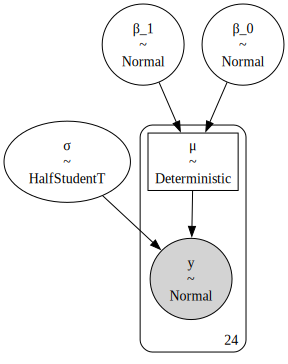

In [8]:
gv = pm.model_to_graphviz(model_objects['linear 1'])
gv.save(filename='linear-1', directory='named-figure/')
gv

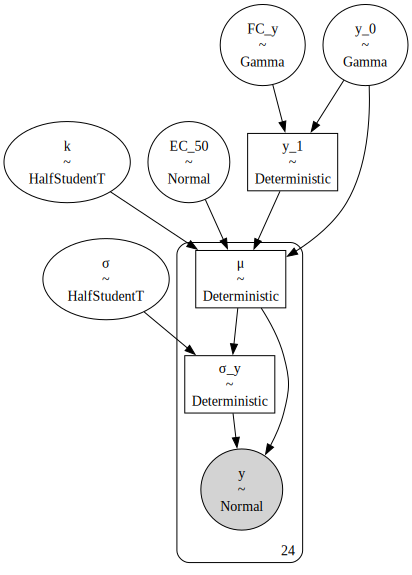

In [9]:
gv = pm.model_to_graphviz(model_objects['sigmoid 2'])
gv.save(filename='sigmoid-2.gv', directory='named-figure/')
gv

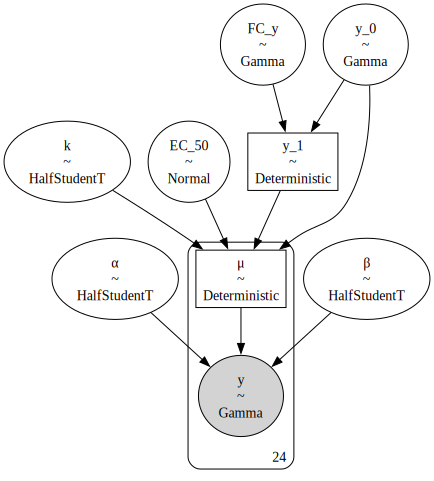

In [10]:
gv = pm.model_to_graphviz(model_objects['sigmoid 4'])
gv.save(filename='sigmoid-4.gv', directory='named-figure/')
gv

In [11]:
model_comparison = az.compare({k: v for k, v in example_idata.items()})
model_comparison

/Users/jonesa7/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
sigmoid 4,0,-77.267356,2.547340,0.000000,9.758142e-01,6.470420,0.000000,True,log
sigmoid 3,1,-78.600127,2.433531,1.332771,0.000000e+00,6.881998,0.821988,False,log
sigmoid 2,2,-87.254280,4.090338,9.986925,2.418578e-02,4.624289,4.846927,True,log
sigmoid 1,3,-97.818899,3.038969,20.551543,0.000000e+00,4.538295,4.831210,False,log
linear 1,4,-98.813446,4.646072,21.546090,6.361578e-13,6.621051,4.542150,False,log


['named-figure/model-comparison.png', 'named-figure/model-comparison.pdf']

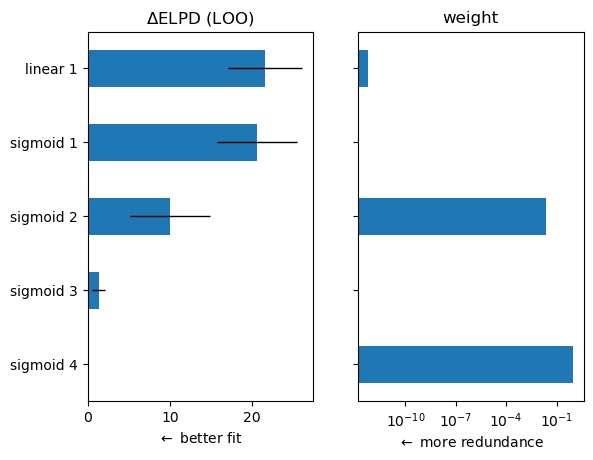

In [12]:
fig, ax = plt.subplots(1, 2, sharey=True)
model_comparison['elpd_diff'].plot(kind='barh', ax=ax[0])
ax[0].errorbar(x='elpd_diff', y='rank', xerr='dse', data=model_comparison, linewidth=0, elinewidth=1, ecolor='k')
model_comparison['weight'].plot(kind='barh', ax=ax[1])
ax[1].set_xscale('log')
ax[0].set_title('$\Delta$ELPD (LOO)')
ax[0].set_xlabel('$\leftarrow$ better fit')
ax[1].set_title('weight')
ax[1].set_xlabel('$\leftarrow$ more redundance')
attila_utils.savefig(fig, 'model-comparison')

In [13]:
ssize = 1000
prior_samples = {m: pm.sample_prior_predictive(model=model_objects[m], samples=ssize) for m in model_objects.keys()}

Sampling: [y, β_0, β_1, σ]
Sampling: [EC_50, FC_y, k, y, y_0, σ]
Sampling: [EC_50, FC_y, k, y, y_0, σ]
Sampling: [EC_50, FC_y, k, y, y_0, α, β]
Sampling: [EC_50, FC_y, k, y, y_0, α, β]


In [14]:
posterior_samples = {m: pm.sample_posterior_predictive(example_idata[m], model=model_objects[m]) for m in example_idata.keys()}

Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


In [15]:
def plot_sampled_curves_linear_1(ax, data=prior_samples['linear 1'].prior, data_reshaped=data_reshaped, color='C0', alpha=0.5):
    xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
    for i in range(data.dims['draw']):
        yy = data['β_0'][0][i].to_numpy() + data['β_1'][0][i].to_numpy() * xx
        ax.plot(xx, yy, linewidth=0.2, color=color, alpha=alpha)
    β_0_mean = data.mean().to_dict()['data_vars']['β_0']['data']
    β_1_mean = data.mean().to_dict()['data_vars']['β_1']['data']
    y_linear_1_mean = β_0_mean + β_1_mean * xx
    ax.plot(xx, y_linear_1_mean, color='red', linewidth=3, label='linear 1')
    return(ax)

In [16]:
def plot_data(ax, data=data_reshaped):
    xx = np.linspace(data.conc_log10.min(), data.conc_log10.max() + 1, 200)
    ax.scatter(x='conc_log10', y='activity', data=data, marker='+', color='k')
    ax.set_xlabel(r'$\log_{10}$ conc')
    ax.set_ylabel(r'activity')
    return(ax)

def plot_sampled_curves_sigmoid_1(ax, idata, data_reshaped=data_reshaped, color='C0', alpha=0.5,
                                  plot_sampled_curves=True, draw_y0_y1=False):
    xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
    chain = 0 # use samples from only one chain
    if plot_sampled_curves:
        for i in range(idata.dims['draw']):
            EC_50 = idata['EC_50'][chain][i].to_numpy()
            k = idata['k'][chain][i].to_numpy()
            y_0 = idata['y_0'][chain][i].to_numpy()
            y_1 = idata['y_1'][chain][i].to_numpy()
            yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
            ax.plot(xx, yy, linewidth=0.2, color=color, alpha=alpha)
    EC_50_mean = idata.mean().to_dict()['data_vars']['EC_50']['data']
    k_mean = idata.mean().to_dict()['data_vars']['k']['data']
    y_0_mean = idata.mean().to_dict()['data_vars']['y_0']['data']
    y_1_mean = idata.mean().to_dict()['data_vars']['y_1']['data']
    y_sigmoid_1_mean = y_1_mean + (y_0_mean - y_1_mean) / (1 + np.exp(k_mean * (xx - EC_50_mean)))
    if draw_y0_y1:
        ax.add_patch(plt.Rectangle((xx[0], 0), xx[-1] - xx[0], y_0_mean * 0.5, ls=None, lw=0, ec="c", fc='green', alpha=0.2))
        linestyle = 'dashed'
        color = 'k'
        linewidth = 1
        ax.axhline(y_0_mean, linestyle='solid', color=color, linewidth=2)
        ax.axhline(y_0_mean * 0.5, linestyle='solid', color=color, linewidth=0.5)
        ax.axhline(y_1_mean, linestyle=linestyle, color=color, linewidth=linewidth)
        labels = ['$y_0$', '$y_0 t$: relevant effect size', '$y_1 = y_0 \mathrm{FC}_y$']
        ax.set_yticks([y_0_mean, y_0_mean * 0.5, y_1_mean], labels=labels)
        ax.text(EC_50_mean - 2, y_0_mean / 4, '$H_1: \mathrm{FC}_y < t$', color='green')
    ax.plot(xx, y_sigmoid_1_mean, color='red', linewidth=3, label='sigmoid 1')
    return(ax)


['named-figure/sigmoid-2-draw_y0_y1.png',
 'named-figure/sigmoid-2-draw_y0_y1.pdf']

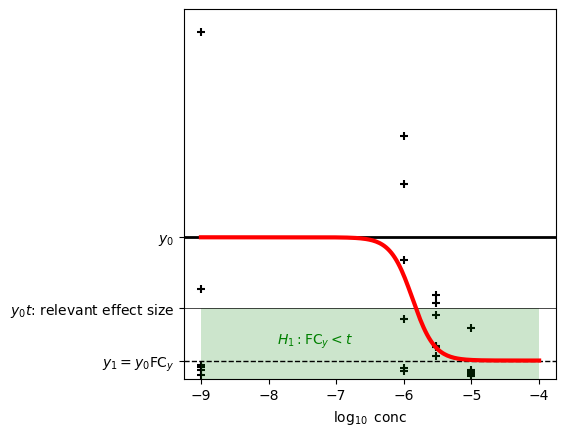

In [17]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))
ax = plot_data(ax, data=data_reshaped)
ax = plot_sampled_curves_sigmoid_1(ax, example_idata['sigmoid 2'].posterior, plot_sampled_curves=False, draw_y0_y1=True)
ax.set_ylim(0, 55)
ax.set_ylabel('')
attila_utils.savefig(fig, 'sigmoid-2-draw_y0_y1')

['named-figure/data-TI26-TNF.png', 'named-figure/data-TI26-TNF.pdf']

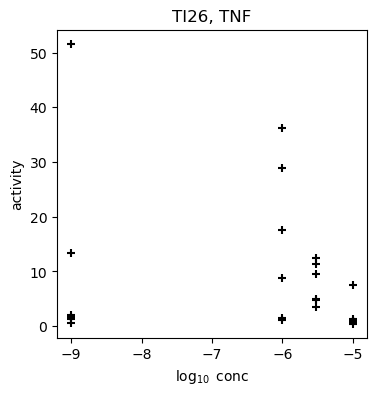

In [18]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = plot_data(ax, data=data_reshaped)
ax.set_title('TI26, TNF')
attila_utils.savefig(fig, 'data-TI26-TNF')

['named-figure/forest-plot-sigmoid-4.png',
 'named-figure/forest-plot-sigmoid-4.pdf']

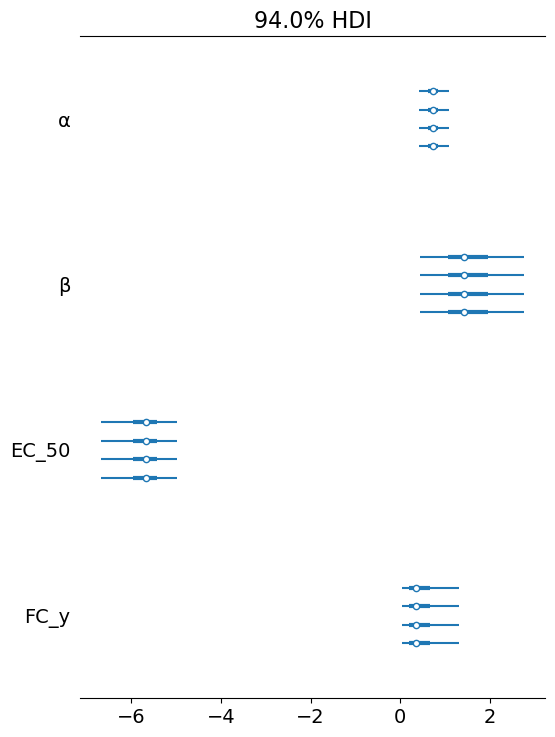

In [19]:
var_names = ['α', 'β', 'EC_50', 'FC_y']
ax = az.plot_forest(example_idata['sigmoid 4'], var_names=var_names)
fig = ax.ravel()[0].figure
attila_utils.savefig(fig, 'forest-plot-sigmoid-4')

In [20]:
az.summary(example_idata['sigmoid 4'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
EC_50,-5.716,0.445,-6.669,-4.988,0.009,0.007,2674.0,1675.0,1.00
y_0,24.812,4.949,15.899,34.268,0.123,0.087,1615.0,1383.0,1.00
FC_y,0.513,0.495,0.032,1.311,0.014,0.010,1191.0,1571.0,1.00
k,13.973,93.817,0.003,23.209,2.390,1.690,2346.0,1461.0,1.00
α,0.745,0.187,0.410,1.096,0.005,0.004,1458.0,1957.0,1.00
β,1.573,0.729,0.438,2.764,0.020,0.015,1601.0,1565.0,1.00
y_1,12.848,12.832,0.733,34.739,0.347,0.246,1099.0,1409.0,1.00
μ[0],14.681,9.789,2.113,32.231,0.289,0.204,923.0,1662.0,1.01
μ[1],18.102,8.354,5.058,31.602,0.223,0.157,1384.0,1745.0,1.01
μ[2],21.551,7.193,9.928,33.643,0.161,0.115,2048.0,1699.0,1.00


<AxesSubplot: xlabel='y / y'>

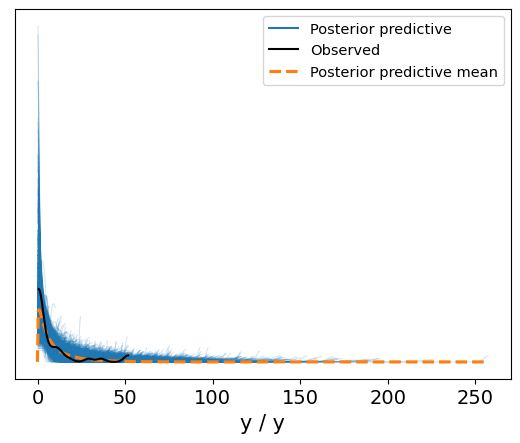

In [21]:
az.plot_ppc(posterior_samples['sigmoid 4'])

In [22]:
model = 'sigmoid 2'
d = pd.DataFrame(posterior_samples[model].posterior_predictive['y'][0], columns=data_reshaped.conc_log10).unstack().to_frame('y')
d['conc_lg'] = d.index.get_level_values(0)
d

y  conc_lg
conc_log10                        
-5.0       0     0.226349     -5.0
           1     0.902186     -5.0
           2     0.499736     -5.0
           3    -3.172404     -5.0
           4     6.412918     -5.0
...                   ...      ...
-9.0       995  13.823416     -9.0
           996  -7.031585     -9.0
           997  35.198700     -9.0
           998  59.537589     -9.0
           999  -0.457230     -9.0

[24000 rows x 2 columns]

['named-figure/posterior-predictive-sigmoid.png',
 'named-figure/posterior-predictive-sigmoid.pdf']

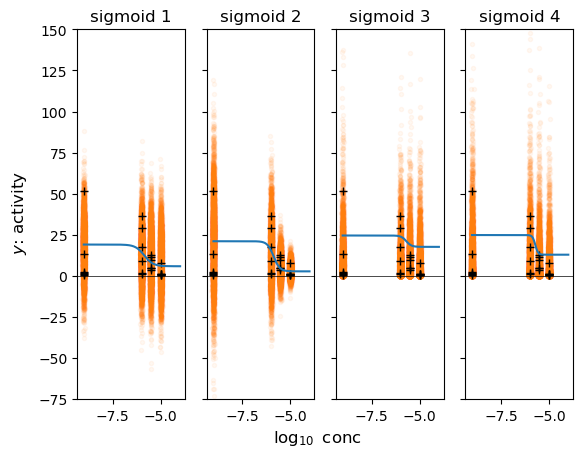

In [23]:
sigmoid_models = [s for s in example_idata.keys() if re.match('^sigmoid.*', s)]
fig, ax = plt.subplots(1, len(sigmoid_models), sharey=True)
for axi, model in zip(ax, sigmoid_models):
    ayy = posterior_samples[model].posterior_predictive['y'][0].transpose().to_numpy()
    axx = data_reshaped.conc_log10.to_numpy().repeat(ayy.shape[1])
    axx += 0.025 * scipy.stats.norm.rvs(size=len(axx))
    ayy = ayy.flatten()
    _ = axi.plot(axx, ayy, linewidth=0, marker='.', color='C1', alpha=0.05)
    _ = axi.plot(data_reshaped.conc_log10, posterior_samples[model].observed_data['y'], linewidth=0, marker='+', color='k', alpha=1)
    means = {k: v['data'] for k, v in example_idata[model].posterior.mean().to_dict()['data_vars'].items()}
    xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
    μ_mean = means['y_1'] + (means['y_0'] - means['y_1']) / (1 + np.exp(means['k'] * (xx - means['EC_50'])))
    axi.plot(xx, μ_mean)
    axi.axhline(0, color='k', linewidth=0.5)
    axi.set_title(model)
    axi.set_ylim(-75, 150)
fig.supxlabel('$\log_{10}$ conc')
fig.supylabel('$y$: activity')
attila_utils.savefig(fig, 'posterior-predictive-sigmoid')

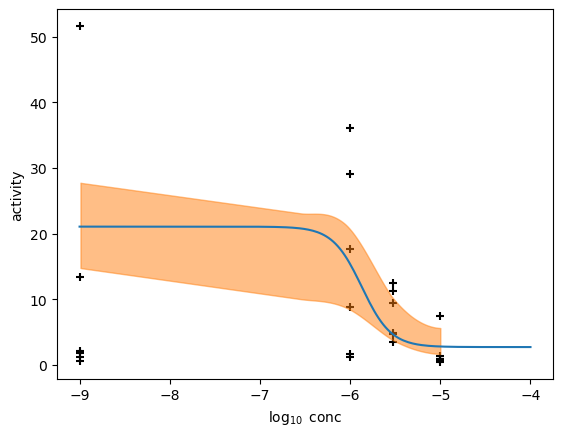

In [24]:
model = 'sigmoid 2'
fig, ax = plt.subplots()
ax = plot_data(ax)
xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
az.plot_hdi(data_reshaped.conc_log10, example_idata[model].posterior['μ'], ax=ax)
means = {k: v['data'] for k, v in example_idata[model].posterior.mean().to_dict()['data_vars'].items()}
μ_mean = means['y_1'] + (means['y_0'] - means['y_1']) / (1 + np.exp(means['k'] * (xx - means['EC_50'])))
ax.plot(xx, μ_mean)

['named-figure/prior-posterior-curves-linear-1.png',
 'named-figure/prior-posterior-curves-linear-1.pdf']

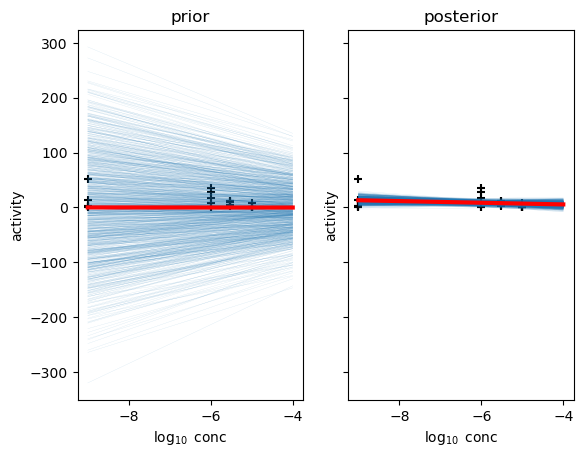

In [25]:
def prior_posterior_curves_linear_1(idata=example_idata):
    fig, ax = plt.subplots(1, 2, sharey=True)
    for axi, idat, prior_posterior in zip(ax, [prior_samples['linear 1'].prior, idata['linear 1'].posterior], ['prior', 'posterior']):
        axi = plot_data(axi)
        axi = plot_sampled_curves_linear_1(ax=axi, data=idat, alpha=0.2)
        axi.set_title(prior_posterior)
    return((fig, ax))

fig, ax = prior_posterior_curves_linear_1()
attila_utils.savefig(fig, 'prior-posterior-curves-linear-1')

['named-figure/prior-posterior-curves-linear-1-zoom.png',
 'named-figure/prior-posterior-curves-linear-1-zoom.pdf']

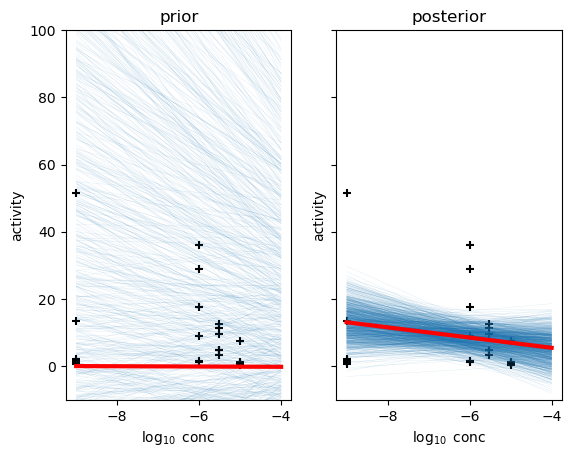

In [26]:
fig, ax = prior_posterior_curves_linear_1()
ax[1].set_ylim(-10, 100)
attila_utils.savefig(fig, 'prior-posterior-curves-linear-1-zoom')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/1086986138.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/1086986138.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/1086986138.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/1086986138.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/1086986138.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/1086986138

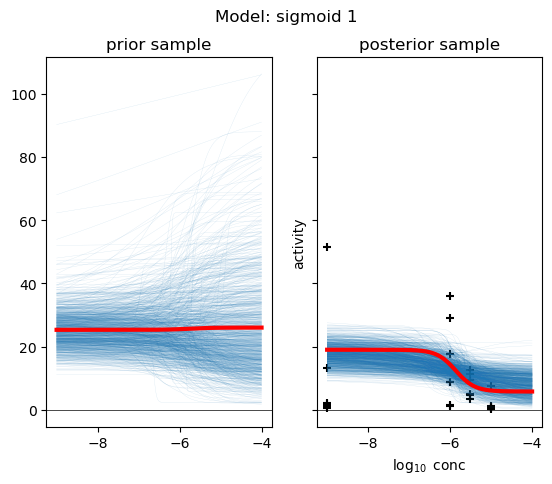

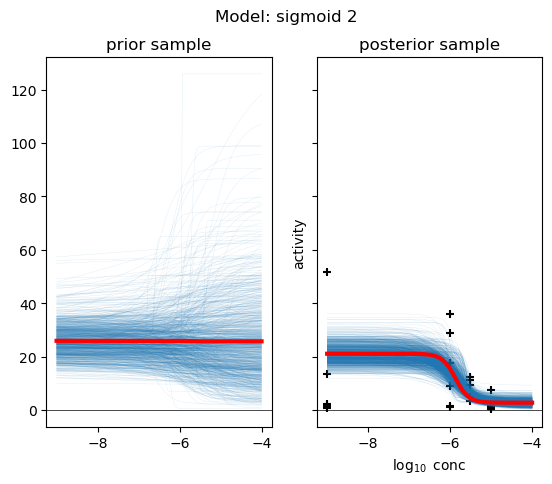

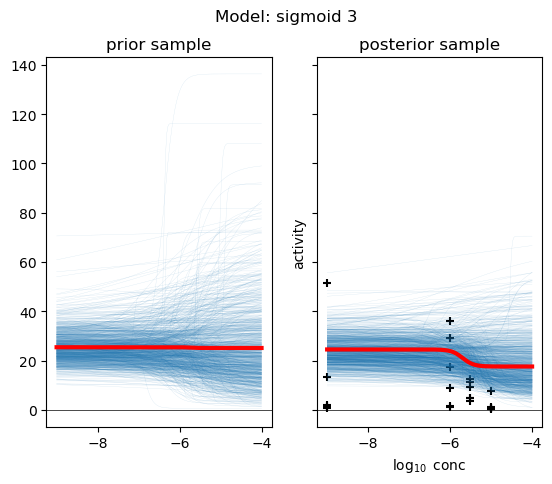

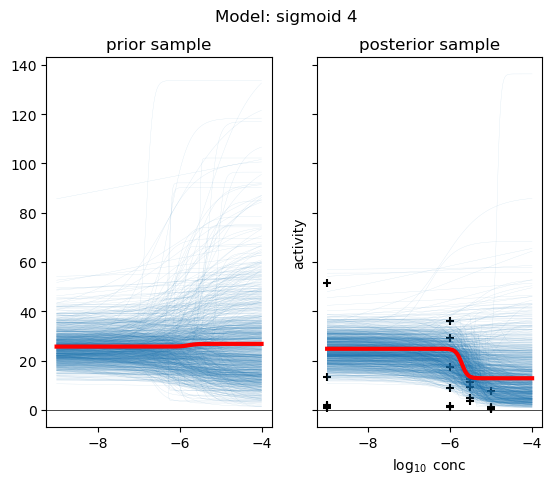

In [27]:
def prior_posterior_curves_sigmoid(model='sigmoid 1', prior_samples=prior_samples, idata=example_idata):
    prior = prior_samples[model].prior
    fig, ax = plt.subplots(1, 2, sharey=True)
    fig.suptitle('Model: ' + model)
    for axi, data, title in zip(ax, [prior, idata[model].posterior], ['prior sample', 'posterior sample']):
        if title == 'posterior sample':
            axi = plot_data(axi)
        axi = plot_sampled_curves_sigmoid_1(ax=axi, idata=data, alpha=0.2)
        axi.set_title(title)
        axi.axhline(0, color='k', linewidth=0.5)
    return((fig, ax))

for i, model in zip(range(len(sigmoid_models)), sigmoid_models):
    fig, ax = prior_posterior_curves_sigmoid(model=model, prior_samples=prior_samples)
    attila_utils.savefig(fig, 'prior-posterior-curves-sigmoid-' + str(i + 1))

['named-figure/mcmc-trace-sigmoid-4.png',
 'named-figure/mcmc-trace-sigmoid-4.pdf']

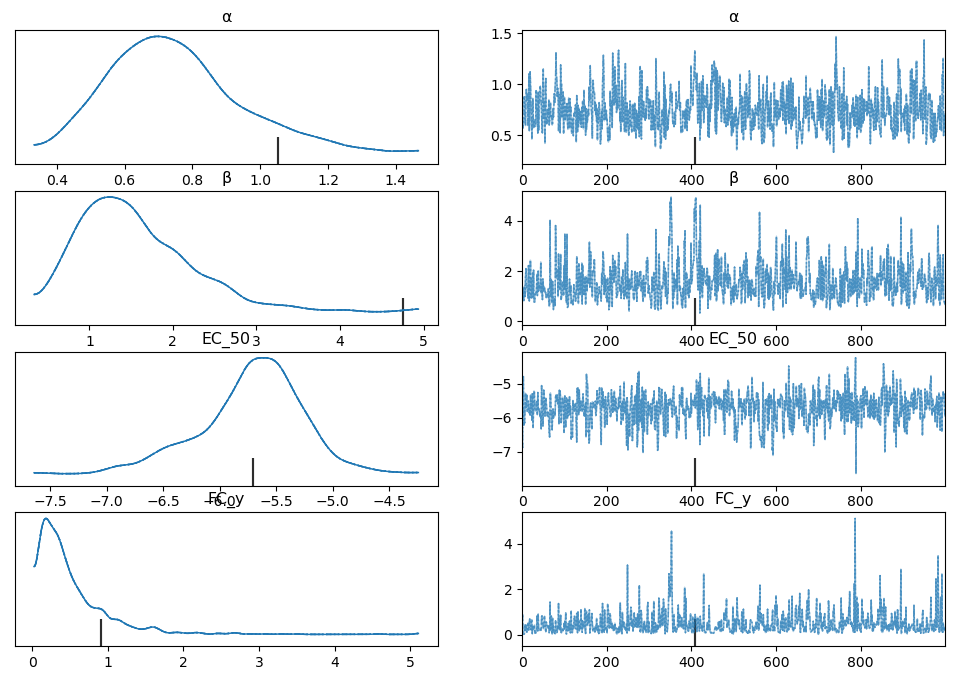

In [28]:
def my_plot_trace(sel_mod='sigmoid 4', var_names=['α', 'β', 'EC_50', 'FC_y'], idata=example_idata):
    ax = az.plot_trace(idata[sel_mod], var_names=var_names)
    fig = ax.ravel()[0].figure
    #fig.suptitle(sel_mod)
    return((fig, ax))

sel_mod = 'sigmoid 4'
fig, ax = my_plot_trace(sel_mod=sel_mod, var_names=['α', 'β', 'EC_50', 'FC_y'])
attila_utils.savefig(fig, 'mcmc-trace-' + sel_mod.replace(' ', '-'))

['named-figure/mcmc-trace-sigmoid-2.png',
 'named-figure/mcmc-trace-sigmoid-2.pdf']

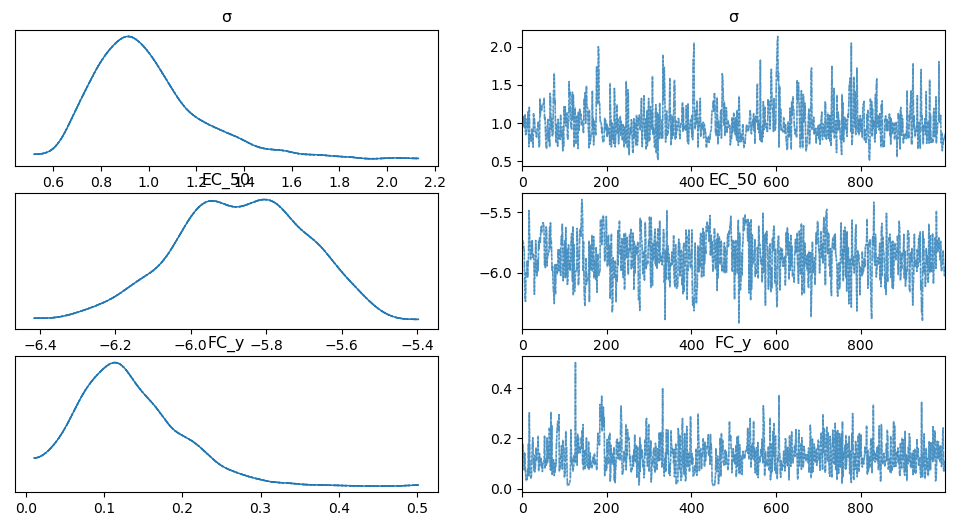

In [29]:
sel_mod = 'sigmoid 2'
fig, ax = my_plot_trace(sel_mod=sel_mod, var_names=['σ', 'EC_50', 'FC_y'])
attila_utils.savefig(fig, 'mcmc-trace-' + sel_mod.replace(' ', '-'))

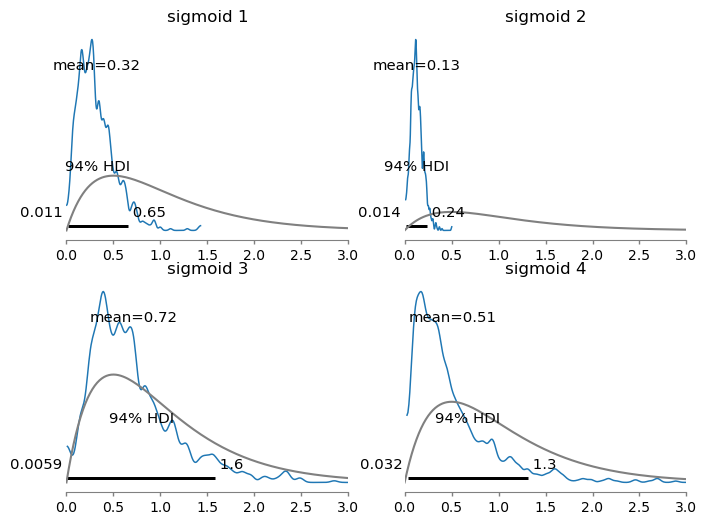

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
for axi, model in zip(ax.ravel(), sigmoid_models):
    az.plot_posterior(example_idata[model], var_names = ['FC_y'], ax=axi, textsize=10)
    xx = np.linspace(0, 5, num=200)
    yy = scipy.stats.gamma.pdf(xx, 2, scale=1/2)
    axi.plot(xx, yy, color='gray')
    axi.set_title(model)
    axi.set_xlim(0, 3)

In [31]:
def get_H1_prob(posterior_idata=example_idata['sigmoid 4'].posterior['FC_y'], t_0=0.5, t_1=None):
    left_tail_prob = sum(sum(posterior_idata < t_0)) if t_0 is not None else 0
    right_tail_prob = sum(sum(posterior_idata > t_1)) if t_1 is not None else 0
    H1_prob = np.float64(left_tail_prob + right_tail_prob)
    H1_prob /= len(posterior_idata.to_numpy().ravel())
    return(H1_prob)

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/134756935.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/134756935.py:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [mpatches.Patch(edgecolor=c, color=c, alpha=alpha) for c in ['C0', 'C1']]


['named-figure/prior-posterior-density-sigmoid-2.png',
 'named-figure/prior-posterior-density-sigmoid-2.pdf']

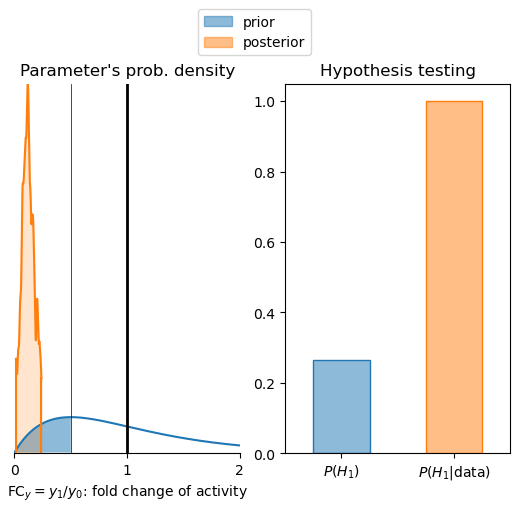

In [32]:
def prior_posterior_density_plot(ax, model='sigmoid 4', x_max=3, t_0=0.5, t_1=None, idata=example_idata):
    alpha = 0.5
    xx = np.linspace(0, x_max, num=200)
    yy_prior = scipy.stats.gamma.pdf(xx, 2, scale=1/2)
    ax.plot(xx, yy_prior, label='prior')
    ax.fill_between(xx, yy_prior, alpha=alpha)
    az.plot_density(idata[model], group='posterior', var_names=['FC_y'], ax=ax, colors='C1', shade=0.2, point_estimate=None)
    where = np.repeat(True, len(xx))
    if t_0 is not None:
        where = where & (xx > t_0)
        ax.axvline(t_0, linewidth=0.5, color='k')
    if t_1 is not None:
        where = where & (xx < t_1)
        ax.axvline(t_1, linewidth=0.5, color='k')
    ax.fill_between(xx, 2, where=where, color='w')
    ax.axvline(1, linewidth=2, color='k', linestyle='solid')
    t = np.repeat(1e3, len(xx))
    ax.set_title('')
    ax.set_xlim(0, x_max)
    ax.set_xlabel('$\mathrm{FC}_y = y_1 / y_0$: fold change of activity')
    ax.margins(y=0)
    return(ax)

def prior_posterior_density_plot_complex(model='sigmoid 4', t_0=0.5, t_1=None, idata=example_idata):
    alpha = 0.5
    fig, ax = plt.subplots(1, 2)
    ax[0] = prior_posterior_density_plot(ax[0], model=model, x_max=2, t_0=t_0, t_1=t_1)
    d = {'prior': scipy.stats.gamma.cdf(0.5, 2, scale=1/2),
         'posterior': get_H1_prob(posterior_idata=idata[model].posterior['FC_y'], t_0=t_0, t_1=t_1)}
    pd.Series(d).plot(kind='bar', ax=ax[1], color=['C0', 'C1'], alpha=alpha)
    pd.Series(d).plot(kind='bar', ax=ax[1], edgecolor=['C0', 'C1'], fill=False, linewidth=1)
    ax[1].set_xticklabels(['$P(H_1)$', '$P(H_1|\mathrm{data})$'], rotation=0)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10)
    ax[0].set_title('Parameter\'s prob. density')
    ax[1].set_title('Hypothesis testing')
    handles = [mpatches.Patch(edgecolor=c, color=c, alpha=alpha) for c in ['C0', 'C1']]
    fig.legend(handles=handles, labels=d.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.05))
    return((fig, ax))

model = 'sigmoid 2'
fig, ax = prior_posterior_density_plot_complex(model=model, t_0=0.5)
attila_utils.savefig(fig, 'prior-posterior-density-' + model.replace(' ', '-'))

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/134756935.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/134756935.py:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [mpatches.Patch(edgecolor=c, color=c, alpha=alpha) for c in ['C0', 'C1']]


['named-figure/prior-posterior-density-sigmoid-4.png',
 'named-figure/prior-posterior-density-sigmoid-4.pdf']

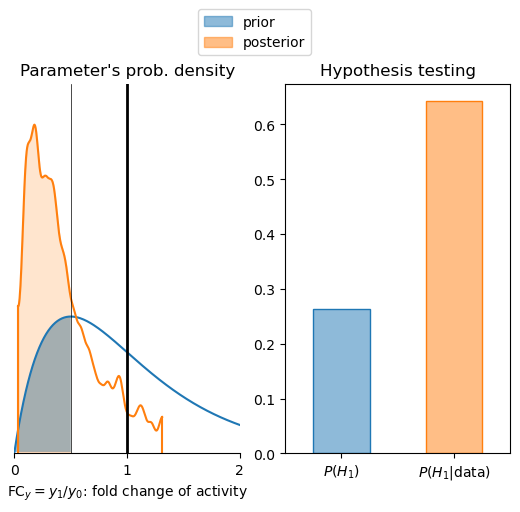

In [33]:
model = 'sigmoid 4'
fig, ax = prior_posterior_density_plot_complex(model=model, t_0=0.5)
attila_utils.savefig(fig, 'prior-posterior-density-' + model.replace(' ', '-'))

In [34]:
drug_concentrations = {
    'TI1': {
        'c1': 100e-6,
        'c2': 10e-6,
        'c3': 1e-6,
        'LC': 1e-9,
    },
    'TI21': {
        'c1': 100e-6,
        'c2': 10e-6,
        'c3': 1e-6,
        'LC': 1e-9,
    },
    'TI26': {
        'c1': 10e-6,
        'c2': 3e-6,
        'c3': 1e-6,
        'LC': 1e-9,
    },
}
assays = ['IL-1b', 'IL-6', 'IL-8', 'MTT', 'TNF']
d = {(d, a): c for d, c in drug_concentrations.items() for a in assays}
experiments = pd.Series(d.values(), index=d.keys()).to_frame('concentrations')
experiments['compound'] = experiments.index.get_level_values(0)
experiments['assay'] = experiments.index.get_level_values(1)
experiments.loc[[('TI1', 'IL-6'), ('TI26', 'IL-1b')]]
experiments

concentrations compound  assay
TI1  IL-1b  {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...      TI1  IL-1b
     IL-6   {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...      TI1   IL-6
     IL-8   {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...      TI1   IL-8
     MTT    {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...      TI1    MTT
     TNF    {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...      TI1    TNF
TI21 IL-1b  {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...     TI21  IL-1b
     IL-6   {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...     TI21   IL-6
     IL-8   {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...     TI21   IL-8
     MTT    {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...     TI21    MTT
     TNF    {'c1': 0.0001, 'c2': 1e-05, 'c3': 1e-06, 'LC':...     TI21    TNF
TI26 IL-1b  {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'LC': ...     TI26  IL-1b
     IL-6   {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'LC': ...     TI26   IL-6
     IL-8   {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'LC': ...     TI26   IL-8
     MTT    {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'LC': ...     TI26    MTT
     TNF    {'c1': 1e-05, 'c2': 3e-06, 'c3': 1e-06, 'LC': ...     TI26    TNF

In [35]:
def fit_model_experiment(compound, assay, concentrations, model='sigmoid 2', n_chains=4, return_model=False, my_models=my_models):
    print(compound, assay)
    my_random_seed = 1949
    data_reshaped = reshape_data(read_data(compound=compound, assay=assay), concentrations=concentrations)
    x_obs = data_reshaped['conc_log10'].values
    y_obs = data_reshaped['activity'].values
    fun = my_models[model]
    EC_50_mu = np.quantile(x_obs, 0.5)
    y_0_alpha = np.quantile(y_obs, 0.9)
    val = fun(y_obs, x_obs, EC_50_mu=EC_50_mu, y_0_alpha=y_0_alpha, return_model=return_model)
    return(val)

E = experiments.loc[[('TI1', 'IL-6'), ('TI26', 'IL-6'), ('TI26', 'IL-1b')]]

def fit_models(models=['sigmoid 2', 'sigmoid 4'], experiments=E):
    def fit_one_model(model):
        l = [experiments.apply(lambda r: fit_model_experiment(**r.to_dict(), model=model, return_model=b),
                     axis=1).to_frame((model, colname)) for b, colname in zip([True, False], ['model', 'idata'])]
        return(pd.concat(l, axis=1))
    l = [fit_one_model(m) for m in models]
    results = pd.concat(l, axis=1)
    return(results)


In [36]:
test_idata = fit_models(models=['sigmoid 2', 'sigmoid 4'])
test_idata

TI1 IL-6
TI26 IL-6
TI26 IL-1b
TI1 IL-6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


TI26 IL-6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.


TI26 IL-1b


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.


TI1 IL-6
TI26 IL-6
TI26 IL-1b
TI1 IL-6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


TI26 IL-6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


TI26 IL-1b


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


sigmoid 2  \
                                               model   
TI1  IL-6   <pymc.model.Model object at 0x168c7c450>   
TI26 IL-6   <pymc.model.Model object at 0x1686e1710>   
     IL-1b  <pymc.model.Model object at 0x169049ad0>   

                                                               \
                                                        idata   
TI1  IL-6   (posterior, log_likelihood, sample_stats, obse...   
TI26 IL-6   (posterior, log_likelihood, sample_stats, obse...   
     IL-1b  (posterior, log_likelihood, sample_stats, obse...   

                                           sigmoid 4  \
                                               model   
TI1  IL-6   <pymc.model.Model object at 0x15f4b4f10>   
TI26 IL-6   <pymc.model.Model object at 0x166face10>   
     IL-1b  <pymc.model.Model object at 0x1646c5210>   

                                                               
                                                        idata  
TI1  IL-6   (posterior, log_likelihood, sample_stats, obse...  
TI26 IL-6   (posterior, log_likelihood, sample_stats, obse...  
     IL-1b  (posterior, log_likelihood, sample_stats, obse...

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/1086986138.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/1086986138.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/1086986138.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_30520/1086986138.py:18: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))


['named-figure/posterior-curves-P-H1-sigmoid-2-vs-sigmoid-4.png',
 'named-figure/posterior-curves-P-H1-sigmoid-2-vs-sigmoid-4.pdf']

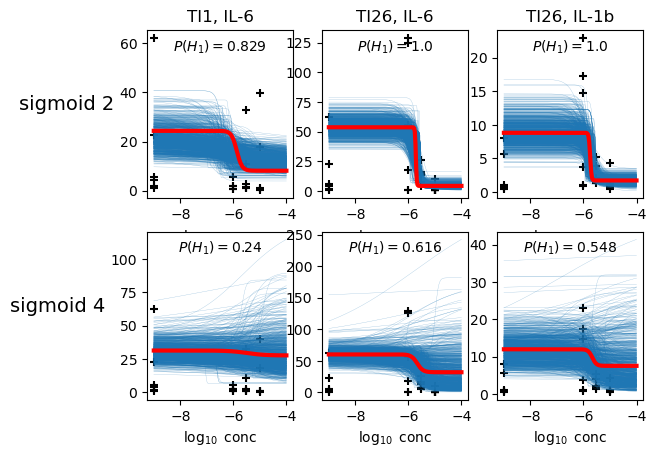

In [37]:
def plot_data_posterior_curves(ax, compound='TI26', assay='IL-1b', model='sigmoid 2', idata=test_idata):
    data_reshaped = reshape_data(read_data(compound=compound, assay=assay), concentrations=concentrations)
    ax = plot_sampled_curves_sigmoid_1(ax, idata=idata.loc[(compound, assay), (model, 'idata')].posterior)
    ax = plot_data(ax, data=data_reshaped)
    return(ax)

fig, ax = plt.subplots(2, test_idata.shape[0])
for axi, ix in zip(ax.transpose(), test_idata.index):
    compound, assay = ix
    for axii, model in zip(axi, test_idata.xs('model', axis=1, level=1).columns):
        plot_data_posterior_curves(axii, compound=compound, assay=assay, model=model, idata=test_idata)
        axii.set_ylabel('')
        H1_prob = get_H1_prob(test_idata.loc[ix, (model, 'idata')].posterior['FC_y'])
        axii.text(0.5, 0.9, '$P(H_1) = {}$'.format(H1_prob), horizontalalignment='center', verticalalignment='center', transform=axii.transAxes)

[axi.set_title(ix[0] + ', ' + ix[1]) for axi, ix in zip(ax[0, :], test_idata.index)]
[axi.set_ylabel(m, rotation=0, fontsize=14, horizontalalignment='right') for axi, m in zip(ax[:, 0], test_idata.xs('model', axis=1, level=1).columns)]
attila_utils.savefig(fig, 'posterior-curves-P-H1-sigmoid-2-vs-sigmoid-4')

In [38]:
s = test_idata.xs('idata', axis=1, level=1)['sigmoid 2']
P_H1_test = s.apply(lambda idat: get_H1_prob(idat.posterior['FC_y'], t_0=0.5))
P_H1_test

TI1   IL-6     0.829
TI26  IL-6     1.000
      IL-1b    1.000
Name: sigmoid 2, dtype: float64

['named-figure/P_H1_test-barchart.png', 'named-figure/P_H1_test-barchart.pdf']

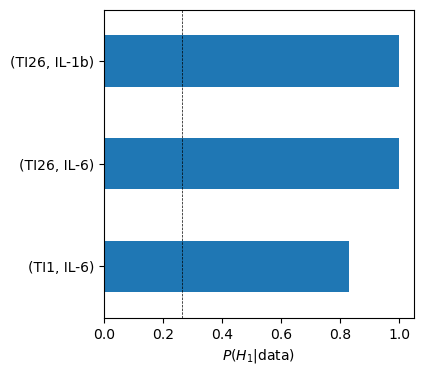

In [39]:
fig, ax = plt.subplots(figsize=(4, 4))
P_H1_test.plot(kind='barh', ax=ax)
P_H1_prior = scipy.stats.gamma.cdf(0.5, 2, scale=1/2)
ax.axvline(P_H1_prior, color='k', linewidth=0.5, linestyle='dashed')
ax.set_xlabel('$P(H_1|\mathrm{data})$')
attila_utils.savefig(fig, 'P_H1_test-barchart')

In [40]:
exp2drop = [('TI21', 'IL-1b'), ('TI21', 'IL-6'), ('TI21', 'IL-8'), ('TI21', 'TNF')]
idata = fit_models(models=['sigmoid 2'], experiments=experiments)

TI1 IL-1b
TI1 IL-6
TI1 IL-8
TI1 MTT
TI1 TNF
TI21 IL-1b
TI21 IL-6
TI21 IL-8
TI21 MTT
TI21 TNF
TI26 IL-1b
TI26 IL-6
TI26 IL-8
TI26 MTT
TI26 TNF
TI1 IL-1b


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


TI1 IL-6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


TI1 IL-8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 284 divergences after tuning. Increase `target_accept` or reparameterize.


TI1 MTT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 180 divergences after tuning. Increase `target_accept` or reparameterize.


TI1 TNF


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


TI21 IL-1b


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.


TI21 IL-6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


TI21 IL-8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


TI21 MTT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


TI21 TNF


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


TI26 IL-1b


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.


TI26 IL-6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.


TI26 IL-8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.


TI26 MTT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


TI26 TNF


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [41]:
s = idata.xs('idata', axis=1, level=1)['sigmoid 2']
P_H1 = s.apply(lambda idat: get_H1_prob(idat.posterior['FC_y'], t_0=0.5))
scorr = pd.concat([experiments.apply(lambda r: spearmanr(read_reshape_data(**r.to_dict()).drop('LC', axis=0, level=1).drop('conc', axis=1))[ix], axis=1).to_frame(colname) for ix, colname in zip(range(2), ['coef', 'pval'])], axis=1)
results = pd.concat([scorr, P_H1.to_frame('P(H_1)')], axis=1)
results['-log p'] = results.pval.apply(lambda p: -np.log10(p))
results

coef      pval  P(H_1)    -log p
TI1  IL-1b  0.445904  0.063639   0.292  1.196274
     IL-6   0.000000  1.000000   0.829 -0.000000
     IL-8   0.183608  0.465823   0.992  0.331779
     MTT   -0.867371  0.000003   1.000  5.501786
     TNF    0.249182  0.318698   0.912  0.496620
TI21 IL-1b -0.407959  0.104040   0.989  0.982799
     IL-6  -0.790453  0.000268   1.000  3.572167
     IL-8  -0.374179  0.138969   1.000  0.857082
     MTT   -0.118094  0.640714   0.002  0.193336
     TNF   -0.682097  0.002559   1.000  2.591972
TI26 IL-1b -0.524593  0.025411   1.000  1.594980
     IL-6  -0.563937  0.014784   1.000  1.830197
     IL-8  -0.367215  0.133857   1.000  0.873359
     MTT   -0.203385  0.418254   0.006  0.378560
     TNF   -0.629512  0.005120   0.999  2.290771

['named-figure/posterior_PH1_vs_spearman_rank.png',
 'named-figure/posterior_PH1_vs_spearman_rank.pdf']

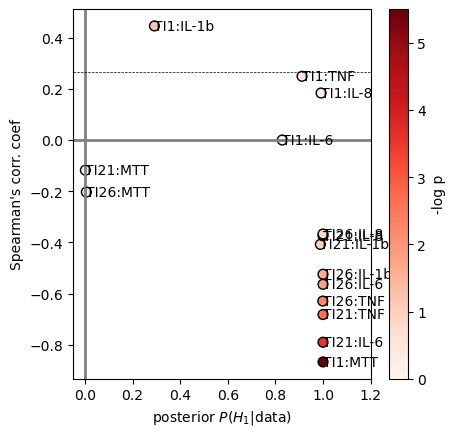

In [43]:
P_H1_prior = scipy.stats.gamma.cdf(0.5, 2, scale=1/2)
fig, ax = plt.subplots(figsize=(4.8, 4.8))
linewidth = 2
color = 'gray'
ax.axvline(0, linewidth=linewidth, color=color)
ax.axhline(0, linewidth=linewidth, color=color)
results.plot(kind='scatter', y='coef', x='P(H_1)', c='-log p', ax=ax, s=50, cmap='Reds', edgecolors='k')
ax.axhline(P_H1_prior, color='k', linewidth=0.5, linestyle='dashed', label='prior $P(H_1)$')
ax.set_xlabel('posterior $P(H_1|\mathrm{data})$')
ax.set_ylabel('Spearman\'s corr. coef')
ax.set_xlim(ax.get_xlim()[0], 1.2)
for ix in results.index:
    compound, assay = ix
    y = results.loc[ix, 'coef']
    x = results.loc[ix, 'P(H_1)']
    ax.text(x=x, y=y, s=compound + ':' + assay, rotation=0, horizontalalignment='left', verticalalignment='center')
attila_utils.savefig(fig, 'posterior_PH1_vs_spearman_rank')

['named-figure/P_H1-barchart.png', 'named-figure/P_H1-barchart.pdf']

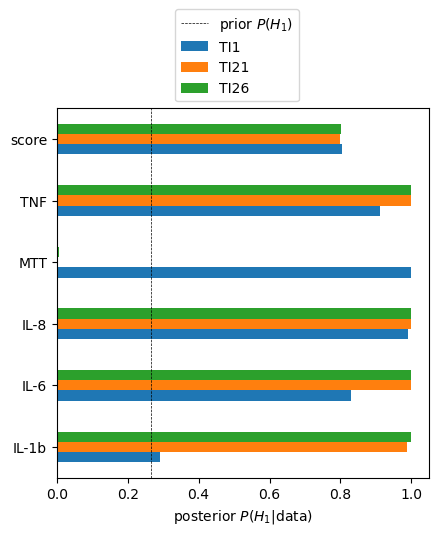

In [44]:
s = P_H1
fig, ax = plt.subplots(figsize=(4.8, 4.8))
df = s.unstack()
df = pd.concat([df, df.mean(axis=1).to_frame('score')], axis=1)
df.transpose().plot(kind='barh', ax=ax, legend=None)
ax.axvline(P_H1_prior, color='k', linewidth=0.5, linestyle='dashed', label='prior $P(H_1)$')
ax.set_xlabel('posterior $P(H_1|\mathrm{data})$')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1))
attila_utils.savefig(fig, 'P_H1-barchart')

['named-figure/P_H1-heatmap.png', 'named-figure/P_H1-heatmap.pdf']

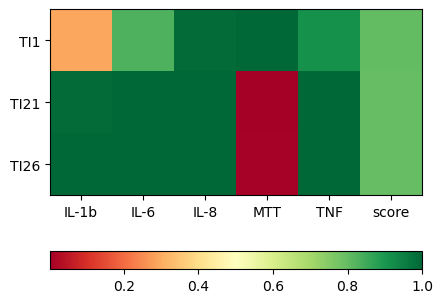

In [45]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))
fontsize = 10
df = s.unstack()
df = pd.concat([df, df.mean(axis=1).to_frame('score')], axis=1)
im = ax.imshow(X=df, cmap='RdYlGn')
cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal')
ax.set_yticks(range(df.shape[0]))
ax.set_yticklabels(df.index, rotation=0, fontsize=fontsize)
ax.set_xticks(range(df.shape[1]))
ax.set_xticklabels(df.columns, rotation=0, fontsize=fontsize)
attila_utils.savefig(fig, 'P_H1-heatmap')

['named-figure/data-posterior-curve-TI26-MTT.png',
 'named-figure/data-posterior-curve-TI26-MTT.pdf']

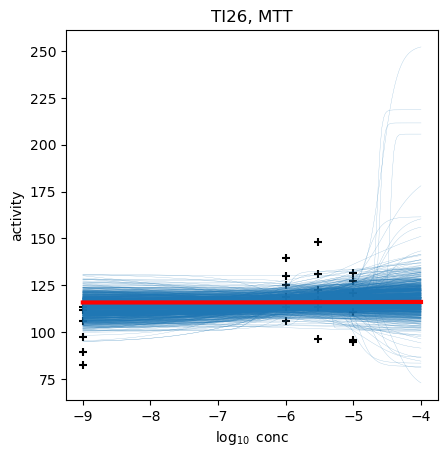

In [46]:
def posterior_sample_plotter(compound='TI26', assay='MTT', experiments=experiments):
    fig, ax = plt.subplots(figsize=(4.8, 4.8))
    concentrations = experiments.loc[(compound, assay), 'concentrations']
    data_reshaped = read_reshape_data(compound=compound, assay=assay, concentrations=concentrations)
    ax = plot_data(ax, data_reshaped)
    ax = plot_sampled_curves_sigmoid_1(ax, idata.loc[(compound, assay), ('sigmoid 2', 'idata')].posterior, data_reshaped=data_reshaped)
    ax.set_title(compound + ', ' + assay)
    return(fig, ax)

compound='TI26'; assay='MTT'
fig, ax = posterior_sample_plotter(compound=compound, assay=assay)
attila_utils.savefig(fig, 'data-posterior-curve-' + compound + '-' + assay)

['named-figure/data-posterior-curve-TI21-MTT.png',
 'named-figure/data-posterior-curve-TI21-MTT.pdf']

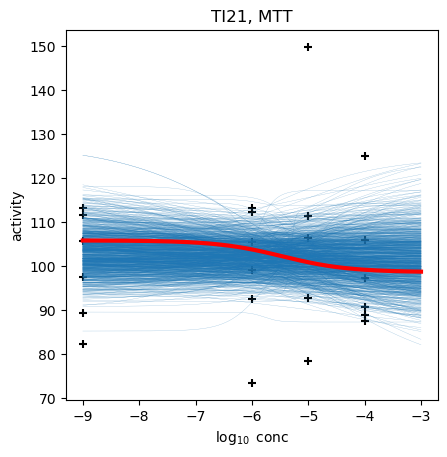

In [47]:
compound='TI21'; assay='MTT'
fig, ax = posterior_sample_plotter(compound=compound, assay=assay)
attila_utils.savefig(fig, 'data-posterior-curve-' + compound + '-' + assay)

['named-figure/data-posterior-curve-TI21-IL-1b.png',
 'named-figure/data-posterior-curve-TI21-IL-1b.pdf']

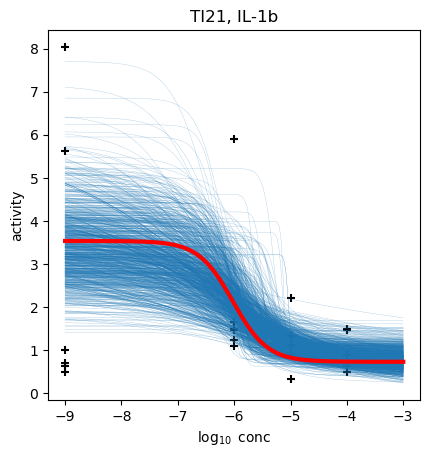

In [48]:
compound='TI21'; assay='IL-1b'
fig, ax = posterior_sample_plotter(compound=compound, assay=assay)
attila_utils.savefig(fig, 'data-posterior-curve-' + compound + '-' + assay)

['named-figure/data-posterior-curve-TI21-TNF.png',
 'named-figure/data-posterior-curve-TI21-TNF.pdf']

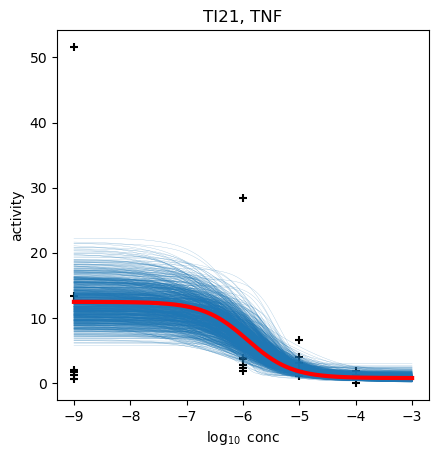

In [49]:
compound='TI21'; assay='TNF'
fig, ax = posterior_sample_plotter(compound=compound, assay=assay)
attila_utils.savefig(fig, 'data-posterior-curve-' + compound + '-' + assay)

In [50]:
%connect_info

{
  "shell_port": 60378,
  "iopub_port": 60379,
  "stdin_port": 60380,
  "control_port": 60382,
  "hb_port": 60381,
  "ip": "127.0.0.1",
  "key": "7e6e41dc-376e01d65dbc837a4b9d8adb",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-57cb3bb3-f7e6-4a41-9f4b-f2db9b08639b.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
